In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [15]:
# Предположим, что некоторый признак может принимать 10 разных значений. 
# В этом случае One Hot Encoding подразумевает создание 10 признаков, все из которых равны нулю за исключением одного. 
# На позицию, соответствующую численному значению признака мы помещаем 1.
# Эта техника реализована в sklearn.preprocessing в классе OneHotEncoder. 
# По умолчанию OneHotEncoder преобразует данные в разреженную матрицу, 
# чтобы не расходовать память на хранение многочисленных нулей.

# наш класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        # transform_mapping - матрица 10 на 10 пока из нулей
        self.transform_mapping = np.zeros((10,10))
        # делаем эту матрицу единичной
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
            
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [16]:
cat = OneHotEncoder()
cat.transform_mapping

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [17]:
cat.transform(5)

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [18]:
# внимание, тут Y_test в обычном формате (не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]): # бежим по объектам тестовой выборки
        y_h = net.forward(X_test[i]) # X_test[i] - признаки i-го объекта, на выходе - вектор вероятностей классов
        y = np.argmax(y_h) # наше предсказание - класс с наибольшей вероятностью
        if y == Y_test[i]:
            acc += 1.0
    # Y_test.shape[0] - количество объектов в тестовой выборке, если всё-всё правильно - acc будет 1
    return acc / Y_test.shape[0]

In [19]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)

# Здесь пока неразбитые тестовая и обучающая выборка для нас
X_train = train_data['data']
Y_train = train_data['target']
# Y_train это x в lambda, это цифра от 0 до 9; соответствующий вектор вероятности будет присваиваться каждому элементу
Y_train_oh = np.array(list(map(lambda x : encoder.transform(x), Y_train)))

# Тестовая выборка для соревнования
X_test = test_data['data']

In [20]:
Y_train[0], Y_train_oh[0]

(7.0, array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]))

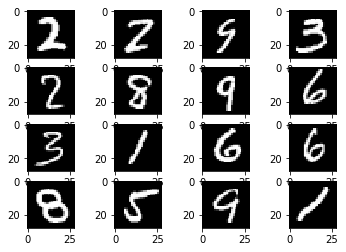

In [21]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [22]:
# такое разбиение данных будет ошибочным, так как нет стратификации по классам при разбиении
# надо использовать sklearn.model_selection.train_test_split

# стратификация по классам - это чтобы в обучающей и валидационной выборках 
# объекты разных классов были представлены в том же соотношении, как и в массивах до разбиения

def divide_data(X, y):
    np.random.seed(11)
    msk = np.random.rand(X.shape[0]) < 0.9
    y_train, X_train = y[msk], X[msk]
    y_test, X_test = y[~msk], X[~msk]
    
    return X_train, y_train, X_test, y_test

In [23]:
# предлагается признаки нормировать центрированием
def data_preparation(X):
    # каждая строчка - наш объект (10000x784), 784 признака у объекта
    # axis=0 - по столбцам (не смешиваем разные признаки)
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    # +0.01 на случай очень маленького std
    X = (X - mean) / (std+0.01)
    plt.imshow(mean.reshape((28, 28)))
    plt.figure()
    
    return X

In [25]:
# X_all = np.concatenate((X_train, X_test), axis = 0)

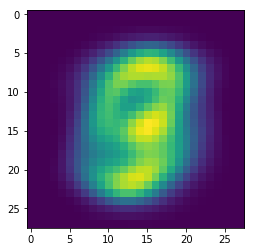

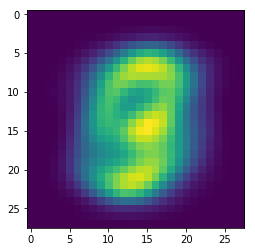

<Figure size 432x288 with 0 Axes>

In [15]:
# Здесь пока неразбитые тестовая и обучающая выборка для нас
X_train = data_preparation(X_train)
X_test = data_preparation(X_test) # ошибка: нормировака теста на его же статистике
X_tr, y_tr, X_ts, y_ts = divide_data(X_train, Y_train_oh)

In [26]:
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_hat = y_hat
        self.y_true = y_true
        return -np.dot(y,np.log(y_hat))
    
    def backward(self, dz, lr=0.001):
        return -1/self.y_hat*self.y_true

In [27]:
class Softmax:
    
    def forward(self, x):
        self.x = x
        return np.exp(x) / np.sum( np.exp(x) )
    
    """
    def backward(self, dz):
        dx = np.zeros(self.x.shape[0])
        s = np.sum(np.exp(self.x))
        for i in range(self.x.shape[0]):
            dx[i] = dz[i]*np.exp(2*self.x[i])/s**2 + dz[i]*np.exp(self.x[i])/s*(1-np.exp(self.x[i])/s) - np.sum(dz*np.exp(self.x)*np.exp(self.x[i])/s**2) 
            
        return dx
    """
    
    def backward(self, dz, lr=0.001):
        sm = self.forward(self.x)
        # матрица, по диагонале которой 1 - exp/sum, а остальные элементы -exp/sum
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)
    
    """
    # здесь неправильно считается производная softmax (ведь это не функция одного аргумента)
    def backward(self, dz):
        return dz * ( self.forward(self.x) * (1 - self.forward(self.x)) )
    """

In [28]:
class Dense: #in_size - размер входного вектора, out_size - размер выхода слоя
    
    def __init__(self, in_size, out_size, rlambda = 0.0):
        # W - матрица весов
        # w_io - вес на ребре, соединяющем i-ый нейрон слоя input с o-ым нейроном слоя output
        # генерим с нулевым средним loc и единичной дисперсией scale
        self.W = np.random.normal(loc = 0., scale=1., size=(out_size, in_size)) * np.sqrt(2 / in_size) #??? np.sqrt(2 / in_size)
        # b - свободный член 
        # (хотя для простоты можно было бы засунуть b как ещё один нейрон in_size слоя с константным выходом 1)
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self): #??? зачем
        # fro - Frobenius norm (корень из суммы квадратов элементов матрицы)
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001): # dz это dL/dz; lr - скорость обучения
        
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x) #outer покомпонентное умножение
        self.db = dz # когда в графе вычислений +, то значение для прохода обратно просто дублируется
        
        # вычисляем производную по входу (следующая эпсилон)
        self.dx = np.matmul(dz, self.W)
        
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        
        # возвращаем dx для продолжения алгоритма
        return self.dx # dz/dx чтобы обучать слои до текущего слоя dL/dx

In [29]:
class ReLU:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz):
        # self.x и dz имеют одинаковые размеры
        # для каждого нейрона нужно вычислить dz * ReLU'(self.x), где ReLU' = 1, если аргумент >= 0 и 0 иначе
        dz[self.x < 0] = 0        
        return dz

In [30]:
# Главная идея Dropout — вместо обучения одной DNN обучить ансамбль нескольких DNN, а затем усреднить полученные результаты,
# предотвращает взаимоадаптацию нейронов на этапе обучения
class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        
        # если отключили dropout
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        
        # с вероятностью p преобразует элемент x в 0, с вероятностью 1-p удваивает элемент x #??? зачем удваивать
        # https://habr.com/ru/company/wunderfund/blog/330814/
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask

In [31]:
# Опеределение самой сети
class MnistNet:
    
    def __init__(self, rlambda=0.0):
        self.d1 = Dense(784, 256, rlambda)
        self.m = ReLU()
        self.d2 = Dense(256, 10, rlambda)
        self.s = Softmax()
    
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.m.forward(net)
        net = self.d2.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz)
        dz = self.d2.backward(dz, lr)
        dz = self.m.backward(dz)
        dz = self.d1.backward(dz, lr)
        return dz

In [18]:
# Здесь процедура обучения
net = MnistNet()
loss = CrossEntropy()
lr = 0.001
L_train = []
L_test = []

for iter in range(20):
    L_acc = 0.
    sh = list(range(X_tr.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh) # modify a sequence in-place by shuffling its contents
    
    for i in range(X_tr.shape[0]):
        x = X_tr[sh[i]]
        y = y_tr[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_acc += L
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_acc /= y_tr.shape[0]
    L_train.append(L_acc)
    L_e_acc = 0.
    for i in range(X_ts.shape[0]):
        x = X_ts[i]
        y = y_ts[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_e_acc += L
    L_e_acc /= y_ts.shape[0]
    L_test.append(L_e_acc)
    e = compute_acc(X_ts, decode(y_ts), net)
    print("{} iter loss. Train : {} . Test : {} . Accur : {}".format(iter, L_acc, L_e_acc, e))

0 iter loss. Train : 0.3278159464666696 . Test : 0.22007565707674234 . Accur : 0.9384321223709369
1 iter loss. Train : 0.15718076760644867 . Test : 0.18653298242745314 . Accur : 0.9537284894837476
2 iter loss. Train : 0.11140714633909424 . Test : 0.1500179770081022 . Accur : 0.9625239005736138
3 iter loss. Train : 0.0841125091665339 . Test : 0.1374641782451584 . Accur : 0.9669216061185468
4 iter loss. Train : 0.0659409910045508 . Test : 0.13971155084772713 . Accur : 0.9674952198852772
5 iter loss. Train : 0.05219820889689291 . Test : 0.13503407796332112 . Accur : 0.9673040152963671
6 iter loss. Train : 0.04597870239164313 . Test : 0.1289092501562192 . Accur : 0.9667304015296367
7 iter loss. Train : 0.03462782278877723 . Test : 0.12882248832155127 . Accur : 0.9686424474187381
8 iter loss. Train : 0.02932490906769196 . Test : 0.12386382860500049 . Accur : 0.9697896749521988
9 iter loss. Train : 0.02419518719315002 . Test : 0.12701114015565543 . Accur : 0.9686424474187381
10 iter loss. Tr

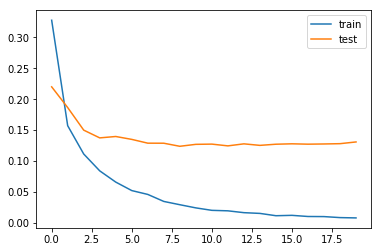

In [19]:
plt.plot(L_train, label='train')
plt.plot(L_test, label='test')
plt.legend()

In [14]:
def decode(Y):
    y = np.zeros(Y.shape[0])
    for i in range(Y.shape[0]):
        y[i] = np.argmax(Y[i])
    return y

In [3]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i]) # X_test[i] - признаки i-го объекта, на выходе - вектор вероятностей классов
            y = np.argmax(y_h) # наше предсказание - класс с наибольшей вероятностью
            fout.write("\n{},{}".format(i, int(y)))

In [20]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_test, net)

In [ ]:
"""""
# Опеределение самой сети
class MnistNet:
    
    def __init__(self, rlambda=0.0):
        self.d1 = Dense(784, 256, rlambda)
        self.dr = Dropout()
        self.m1 = ReLU()
        self.d2 = Dense(256, 50, rlambda)
        self.m2 = ReLU()
        self.d3 = Dense(50, 10, rlambda)
        self.s = Softmax()
    
    def forward_drop(self, x):
        net = self.d1.forward(x)
        net = self.dr.forward(net) #на train есть dropout, на test нет
        net = self.m1.forward(net)
        net = self.d2.forward(net)
        net = self.m2.forward(net)
        net = self.d3.forward(net)
        net = self.s.forward(net)
        return net
    
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.m1.forward(net)
        net = self.d2.forward(net)
        net = self.m2.forward(net)
        net = self.d3.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward_drop(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.d3.backward(dz, lr)
        dz = self.m2.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.m1.backward(dz, lr)
        dz = self.dr.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.d3.backward(dz, lr)
        dz = self.m2.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.m1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz
"""""

In [ ]:
"""""
# Здесь процедура обучения
net = MnistNet()
loss = CrossEntropy()
lr = 0.001
L_train = []
L_test = []
e = []
for iter in range(70):
    L_acc = 0.
    sh = list(range(X_tr.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    for i in range(X_tr.shape[0]):
        x = X_tr[sh[i]]
        y = y_tr[sh[i]]
        y_h = net.forward_drop(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_acc += L 
        dz = loss.backward(1, lr)
        dz = net.backward_drop(dz, lr)
        
    L_acc /= y_tr.shape[0]
    L_train.append(L_acc)
    L_e_acc = 0.
    for i in range(X_ts.shape[0]):
        x = X_ts[i]
        y = y_ts[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_e_acc += L
    L_e_acc /= y_ts.shape[0]
    L_test.append(L_e_acc)
    e = compute_acc(X_ts, decode(y_ts), net)
    print("{} iter loss. Train : {} . Test : {} . Accur : {}".format(iter, L_acc, L_e_acc, e))
"""""